In [1]:
import torch
from torch.utils.data import DataLoader
import importlib
import numpy as np
import torch.nn as nn
import time
from tqdm.notebook import tqdm
import copy
import os
import pickle
from glob import glob

Run the following code block every time you modify utils

In [2]:
from utils import preprocess, dataset, network, train, report
importlib.reload(preprocess)
importlib.reload(dataset)
importlib.reload(network)
importlib.reload(train)
importlib.reload(report)

<module 'utils.report' from '/Users/delphynium/Documents/research projects/EHR-Distillation/utils/report.py'>

1. Compute statistics from training set.

In [3]:
load_from_saved = True
stat_pkl_dir = "./saved_data/stats/"
if not os.path.exists(stat_pkl_dir):
    os.makedirs(stat_pkl_dir)

categorical_numcls = {  # how many classes are there for categorical classes
    "capillary_refill_rate": 2,
    "glascow_coma_scale_eye_opening": 4,
    "glascow_coma_scale_motor_response": 6,
    "glascow_coma_scale_total": 13,
    "glascow_coma_scale_verbal_response": 5,
}

pkl_path = os.path.join(stat_pkl_dir, "ihm_preliminary.pkl")
if os.path.exists(pkl_path) and load_from_saved:
    with open(pkl_path, 'rb') as f:
        continuous_avgs_train, continuous_stds_train, categorical_modes_train = pickle.load(f)
else:
    continuous_avgs_train, continuous_stds_train, categorical_modes_train =  preprocess.compute_feature_statistics(
        ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
        feature_dict=preprocess.mimic3_benchmark_variable_dict
        )
    with open(pkl_path, 'wb') as f:
        pickle.dump((continuous_avgs_train, continuous_stds_train, categorical_modes_train), f)

2. Clean all data by resampling.
Running this block once is enough.
Cleaned data will be saved at ./data/mimic3/ihm_preliminary/

In [7]:
preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
    output_dir="./data/mimic3/ihm_preliminary/train/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=continuous_avgs_train|categorical_modes_train
    )
preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/test/",
    output_dir="./data/mimic3/ihm_preliminary/test/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=continuous_avgs_train|categorical_modes_train
    )

100%|██████████| 3236/3236 [01:28<00:00, 36.45it/s]


3. Prepare real training set and test set. You may have to re-run this block after modifying dataloader-related codes.

In [4]:
# Load datasets
# Pay attention to the balance and mask settings

train_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=False,
    mask=False,
    )
print(f"First item in the dataset: \n{train_set[0]}")
print(f"Feature tensor shape: {train_set[0][0].shape}")

test_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/test/",
    dstype="test",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=False,
    mask=False,
    )
print(f"First item in the dataset: \n{test_set[0]}")
print(f"Feature tensor shape: {test_set[0][0].shape}")

input_shape = train_set[0][0].shape

First item in the dataset: 
(tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.8303e-16],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.8303e-16],
        [ 1.0000e+00,  0.0000e+00,  3.9972e-02,  ...,  5.6418e-02,
          1.4145e+00,  4.7770e-02],
        ...,
        [ 1.0000e+00,  0.0000e+00,  2.6577e-02,  ...,  8.5097e-02,
          1.4145e+00,  9.9521e-02],
        [ 1.0000e+00,  0.0000e+00,  1.0695e-01,  ..., -1.8149e-02,
          1.4145e+00,  9.9521e-02],
        [ 1.0000e+00,  0.0000e+00,  2.2111e-02,  ..., -1.8149e-02,
          1.4145e+00,  9.9521e-02]]), tensor(0))
Feature tensor shape: torch.Size([48, 42])
First item in the dataset: 
(tensor([[ 1.0000,  0.0000, -0.0583,  ..., -0.0835,  0.0000,  0.0607],
        [ 1.0000,  0.0000, -0.0449,  ...,  0.0197,  0.0000,  0.0607],
        [ 1.0000,  0.0000, -0.0806,  ...,  0.0507,  0.0000,  0.0564],
        ...,
        [ 1.0000,  0.0000, -0.04

4. See label distribution in training set.

In [8]:
label_0_cnt = 0
label_1_cnt = 1
for _, label in train_set:
    if label > 0.5:
        label_1_cnt += 1
    else:
        label_0_cnt += 1
print(f"Label 0 ratio: {label_0_cnt / (label_0_cnt + label_1_cnt)}")
print(f"Label 1 ratio: {label_1_cnt / (label_0_cnt + label_1_cnt)}")

Label 0 ratio: 0.8646112600536193
Label 1 ratio: 0.1353887399463807


5. Define device

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


6. Evaluate model on original downstream task (in-hospital mortality prediction /binary classification)

In [13]:
# define hyperparams

ihm_epoch = 100
ihm_batch_size = 256
ihm_lr = 0.001
ihm_wd = 0.001

In [53]:
# train 1D CNN
num_workers = 8
pkl_save_dir = "./saved_data/ihm_model/"
if not os.path.exists(pkl_save_dir):
    os.makedirs(pkl_save_dir)

train_loader = DataLoader(train_set, ihm_batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_set, ihm_batch_size, num_workers=num_workers)

model = network.IHMPreliminary1DCNN(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=ihm_lr, weight_decay=ihm_wd)
criterion = nn.CrossEntropyLoss()


pbar = tqdm(range(ihm_epoch), desc="Training on original task")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", train_loader, model, criterion, optimizer, device)
    test_loss, test_acc = train.epoch("test", test_loader, model, criterion, device=device)
    if train_loss < min_loss:
        filename = f'ihm_1dcnn_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(pkl_save_dir, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(pkl_save_dir) if f.startswith(f'ihm_1dcnn_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(pkl_save_dir, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_description(f"Training on original task, epoch {e}\ntrain loss = {train_loss}, train acc = {train_acc}\ntest loss = {test_loss}, test acc = {test_acc}")

Training on original task:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# train MLP
num_workers = 8
pkl_save_dir = "./saved_data/ihm_model/"
if not os.path.exists(pkl_save_dir):
    os.makedirs(pkl_save_dir)

train_loader = DataLoader(train_set, ihm_batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_set, ihm_batch_size, num_workers=num_workers)

model = network.IHMPreliminaryMLP(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=ihm_lr, weight_decay=ihm_wd)
criterion = nn.CrossEntropyLoss()


pbar = tqdm(range(ihm_epoch), desc="Training on original task")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", train_loader, model, criterion, optimizer, device)
    test_loss, test_acc = train.epoch("test", test_loader, model, criterion, device=device)
    if train_loss < min_loss:
        filename = f'ihm_mlp_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(pkl_save_dir, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(pkl_save_dir) if f.startswith(f'ihm_mlp_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(pkl_save_dir, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_description(f"Training on original task, epoch {e}\ntrain loss = {train_loss}, train acc = {train_acc}\ntest loss = {test_loss}, test acc = {test_acc}")

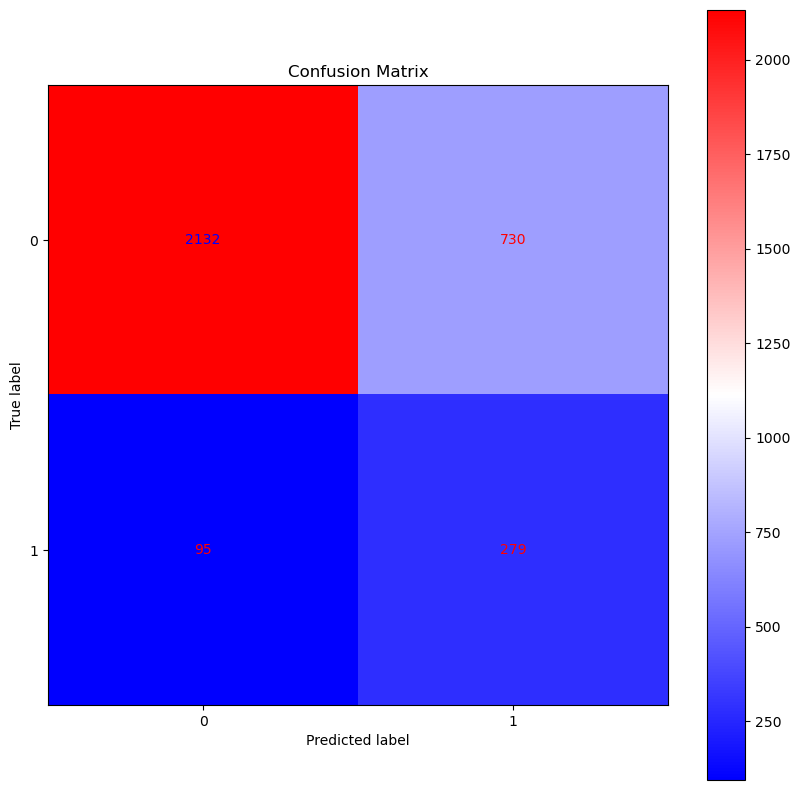

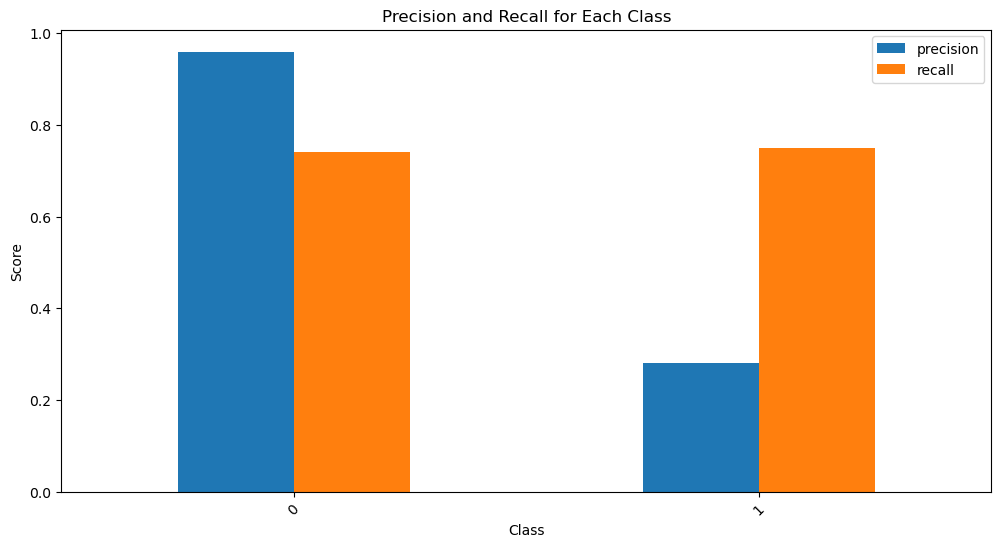

Macro AUC-ROC score: 0.8231248855555182


In [27]:
# Evaluate saved model
pt_save_dir = "./saved_data/ihm_model/"
model_name = "ihm_1dcnn_*_balanced.pt"
eval_model = network.IHMPreliminary1DCNN(input_shape=(48, 42))

model_pt = glob(os.path.join(pt_save_dir, model_name))[0]
model_data = torch.load(model_pt, map_location=torch.device(device))

eval_model.load_state_dict(model_data["model_state_dict"])
eval_model.to(device)
eval_model.eval()

num_workers = 8
balanced_test_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/test/",
    dstype="test",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=True,
    mask=False,
    )
test_loader = DataLoader(test_set, ihm_batch_size, num_workers=num_workers) # pay attention to the test set used here

report.run_classificatoin_report(eval_model, test_loader)

7. Start to distill EHR dataset.

In [66]:
# define hyper params

train_it = 100
lr_data = 0.01
lr_net = 0.01
episodes_per_cls = 10
num_outer_loop = 10
num_inner_loop = 50
real_batch_size = 256
syn_batch_size = 256


In [47]:
# initialize synthetic data

episodes_syn = torch.randn(size=(2*episodes_per_cls, input_shape[0], input_shape[1]), dtype=torch.float, requires_grad=True) # device is ignored by far
labels_syn = torch.tensor(np.array([np.ones(episodes_per_cls)*i for i in (0, 1)]), dtype=torch.long, requires_grad=False).view(-1) # 1-D, length = episodes_per_cls * 2

In [48]:
# define training optimizers and criterion
optimizer_ts = torch.optim.SGD([episodes_syn,], lr=lr_data, momentum=0.5) # optimizer for synthetic data
optimizer_ts.zero_grad()
criterion = nn.CrossEntropyLoss()
print("Ready for training")

Ready for training


In [67]:
# Train with matching loss
# TODO: device

pkl_save_dir = "./saved_data"
if not os.path.exists(pkl_save_dir):
    os.makedirs(pkl_save_dir)
pbar = tqdm(range(train_it), desc="Training iteration")
for it in pbar:

    # Evaluate synthetic data
    # TODO

    # Train synthetic data
    torch.random.manual_seed(int(time.time() * 1000) % 100000) # random init network
    net = network.IHMPreliminary1DCNN(input_shape=input_shape)
    net.train()
    net_params = list(net.parameters())

    optimizer_net = torch.optim.SGD(net.parameters(), lr=lr_net)
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(num_outer_loop):
        # update synthetic data
        loss = torch.tensor(0.0)
        for cls in (0, 1):
            ts_real, lab_real = train_set.random_sample_from_class(n_samples=real_batch_size, cls=cls)
            ts_syn = episodes_syn[cls*episodes_per_cls: (cls+1)*episodes_per_cls]
            lab_syn = labels_syn[cls*episodes_per_cls: (cls+1)*episodes_per_cls]

            out_real = net(ts_real)
            loss_real = criterion(out_real, lab_real)
            grad_real = torch.autograd.grad(loss_real, net_params)
            grad_real = [_.detach().clone() for _ in grad_real]

            out_syn = net(ts_syn)
            loss_syn = criterion(out_syn, lab_syn)
            grad_syn = torch.autograd.grad(loss_syn, net_params, create_graph=True) # create_graph: will be used to compute higher-order derivatives

            # compute gradient matching loss, here using MSE, instead of the one proposed in DCwMG because it's too complicated
            dis = torch.tensor(0.0)
            grad_real_vec = []
            grad_syn_vec = []
            for ig in range(len(grad_real)):
                grad_real_vec.append(grad_real[ig].reshape((-1)))
                grad_syn_vec.append(grad_syn[ig].reshape((-1)))
            grad_real_vec = torch.cat(grad_real_vec, dim=0)
            grad_syn_vec = torch.cat(grad_syn_vec, dim=0)
            dis = torch.sum((grad_syn_vec - grad_real_vec)**2)

            loss += dis
        
        optimizer_ts.zero_grad()
        loss.backward()
        optimizer_ts.step()
        loss_avg += loss.item()

        if ol == num_outer_loop - 1:
            break

        # update network
        episodes_syn_train, labels_syn_train = copy.deepcopy(episodes_syn.detach()), copy.deepcopy(labels_syn.detach())  # avoid any unaware modification
        syn_dataset = dataset.TensorDataset(episodes_syn_train, labels_syn_train)
        train_loader = DataLoader(syn_dataset, syn_batch_size, shuffle=True)
        for il in range(num_inner_loop):
            train.epoch("train", train_loader, net, optimizer_net, criterion)

    loss_avg /= (2 * num_outer_loop)
    pbar.set_description(f"Training iteration, average loss = {loss_avg}")

torch.save({"data": (copy.deepcopy(episodes_syn.detach()), copy.deepcopy(labels_syn.detach()))},
           os.path.join(pkl_save_dir, "distilled_dataset.pt")
           )



Training iteration:   0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
# Train with vanilla method

# Vanilla Dataset Distillation intends to get dataset that is able to train a model within only 1 epoch

# define hyper params
num_optim_it = 100
init_lr = 0.001
step_size = 0.001
init_weights_distr = "kaiming"
batch_size = 256
num_sampled_models = 16
ts_per_cls = 100

# initialize random synth dataset
ts_syn = torch.randn(size=(2*ts_per_cls, input_shape[0], input_shape[1]), dtype=torch.float, requires_grad=True).to(device) # device is ignored by far
lab_syn = torch.tensor(np.array([np.ones(ts_per_cls)*i for i in (0, 1)]), dtype=torch.long, requires_grad=False).view(-1).to(device) # 1-D, length = episodes_per_cls * 2

# initialize learning rate
lr = torch.tensor([init_lr], dtype=torch.float, requires_grad=True).to(device) # make it learnable

optimizer_ts = torch.optim.Adam([ts_syn], lr=step_size)
optimizer_lr = torch.optim.Adam([lr], lr=step_size)

loss_fn = torch.nn.CrossEntropyLoss()

# begin training steps
pbar = tqdm(range(num_optim_it), desc="Training iteration")
for it in pbar:
    # get a minibatch of real training data
    # Sample from class 0
    ts_class_0, lab_class_0 = train_set.random_sample_from_class(n_samples=batch_size//2, cls=0)
    # ts_class_0, lab_class_0 = train_set.first_n_samples_from_class(n_samples=batch_size//2, cls=0)
    # Sample from class 1
    ts_class_1, lab_class_1 = train_set.random_sample_from_class(n_samples=batch_size//2, cls=1)
    # ts_class_1, lab_class_1 = train_set.first_n_samples_from_class(n_samples=batch_size//2, cls=1)
    # Concatenate the time series data along the first dimension (batch size)
    ts_real = torch.cat((ts_class_0, ts_class_1), dim=0).to(device)
    # Concatenate the labels along the 0th dimension
    lab_real = torch.cat((lab_class_0, lab_class_1), dim=0).to(device)
    # print(ts_real.shape, lab_real.shape) # batch_size * num_time_steps * num_features

    # sample a batch of models
    sampled_models = []
    for j in range(num_sampled_models):
        torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
        # torch.random.manual_seed(42) # fixed seed
        model = network.IHMPreliminary1DCNN(input_shape=input_shape, init_distr=init_weights_distr).to(device)
        model.train()
        sampled_models.append(model)
        
    optimizer_ts.zero_grad()
    optimizer_lr.zero_grad()

    losses = []
    for model in sampled_models:
        # Step 1: Train each sampled model on synthetic dataset
        pred_syn = model(ts_syn)
        loss_syn = loss_fn(pred_syn, lab_syn)
        
        for m in model.modules():
            param_names = []
            new_params = []
            for n, p in m.named_parameters(recurse=False): # name is the param's name alone instead of module.name
                gp, = torch.autograd.grad(loss_syn, p, create_graph=True) # enabling higher-order derivatives
                new_p = p - lr * gp
                param_names.append(n) # save them, to delete leaf params later in another enumeration
                new_params.append(new_p) # save them, to reset non-leaf params later in another enumeration
            for i, n in enumerate(param_names):
                delattr(m, n)
                setattr(m, n, new_params[i])

        # Step 2: Evaluate the objective function on real training data
        pred_real = model(ts_real)
        loss_real = loss_fn(pred_real, lab_real)
        losses.append(loss_real)

        # Clear gradients for the next model
        model.zero_grad()

    # Check if params are swapped as non-leaves
    for model in sampled_models:
        for m in model.modules():
            for n, p in m.named_parameters(recurse=False): # name is the param's name alone instead of module.name
                print(p.grad_fn)
    
    # Step 3: Update synthetic data and learnable learning rate
    total_loss = sum(losses)
    total_loss.backward()  # Compute gradients based on real data losses

    # Update synthetic data and learning rate
    # print(lr.grad) # shouldn't be none
    # print(ts_syn.grad) # shouldn't be none
    optimizer_ts.step()
    optimizer_lr.step()

    # Logging the progress
    pbar.set_postfix({"loss": f"{total_loss.item():.4f}",
                      "learnable lr": f"{lr.item()}",
                      })

Training iteration:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

8. Evaluate the distilled dataset

In [8]:
# Simultaneously train 2 models on distilled dataset and original dataset, compare performance
episodes_per_cls = 10

real_batch_size = 256
syn_batch_size = 2*episodes_per_cls

pt_save_dir = "./saved_data"
syn_pt = "distilled_dataset.pt"
syn_pt_path = glob(os.path.join(pt_save_dir, syn_pt))[0]
syn_data = torch.load(syn_pt_path, map_location=torch.device(device))
syn_ts, syn_lab = syn_data["data"]
syn_ts = syn_ts.to(device)
syn_lab = syn_lab.to(device)
syn_set = dataset.TensorDataset(syn_ts, syn_lab)
syn_loader = DataLoader(syn_set, 2*episodes_per_cls)

num_workers = 8
real_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=True,
    mask=True,
    )
real_loader = DataLoader(real_set, real_batch_size, num_workers=num_workers)

model_syn = network.IHMPreliminary1DCNN().to(device)
model_real = network.IHMPreliminary1DCNN().to(device)

train_epoch = 100
lr = 0.01

optimizer_syn = torch.optim.SGD(model_syn.parameters(), lr)
optimizer_syn.zero_grad()
optimizer_real = torch.optim.SGD(model_real.parameters(), lr)
optimizer_real.zero_grad()
criterion = nn.CrossEntropyLoss()

model_syn.train()
model_real.train()

pbar = tqdm(range(train_epoch), desc="Evaluating synthetic dataset")
for e in pbar:
    train.epoch("train", syn_loader, model_syn, criterion, optimizer_syn, device)
    syn_loss, syn_acc = train.epoch("test", real_loader, model_syn, criterion, optimizer_syn, device)
    real_loss, real_acc = train.epoch("train", real_loader, model_real, criterion, optimizer_real, device)
    
    pbar.set_description(f"Evaluating epoch {e}\nsyn loss = {syn_loss}, syn acc = {syn_acc}\nreal loss = {real_loss}, real acc = {real_acc}")


Evaluating synthetic dataset:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 